In [ ]:
!pip install pybullet
!pip install gymnasium pybullet stable-baselines3[extra]

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pybullet as p
import pybullet_data
import time
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [46]:
class CupGraspingEnv(gym.Env):
    def __init__(self):
        super(CupGraspingEnv, self).__init__()

        self.client = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # AXYZ 이동 + 그리퍼
        action_bound = 0.1
        self.action_space = spaces.Box(
            low=np.array([-action_bound]*3 + [0]),
            high=np.array([action_bound]*3 + [1]),
            shape=(4,),
            dtype=np.float32
        )

        # Observation Space : 그리퍼(3), 컵(3), 관절각도(9), 그리퍼 상태(1), 상대위치(3) -> 총 19차원
        obs_dim = 3 + 3 + 9 + 1 + 3
        obs_low = np.array([-np.inf] * obs_dim)
        obs_high = np.array([np.inf] * obs_dim)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.robotId = None
        self.cupId = None
        self.end_effector_index = 8 # Panda 로봇의 손목 바로 위 링크
        self.gripper_indices = [9, 10] # Panda 로봇의 손가락 관절
        self.distance_to_cup = 0
        self.max_steps_per_episode = 500
        self.step_counter = 0
        print("맞춤형 Gym 환경이 [Panda Grasping 버전]으로 생성되었습니다!")

    def reset(self, seed=None, options=None):
        self.step_counter = 0
        p.resetSimulation(physicsClientId=self.client)
        p.setGravity(0, 0, -9.8)

        p.loadURDF("plane.urdf")
        self.robotId = p.loadURDF("franka_panda/panda.urdf", [0, 0, 0], useFixedBase=True)

        # 1. '커리큘럼 학습'을 위해 컵 위치를 고정
        cup_start_pos = [0.5, 0.2, 0.05]
        cup_visual_shape = p.createVisualShape(p.GEOM_CYLINDER, radius=0.04, length=0.1, rgbaColor=[0.8, 0.2, 0.2, 1])
        cup_collision_shape = p.createCollisionShape(p.GEOM_CYLINDER, radius=0.04, height=0.1)
        self.cupId = p.createMultiBody(baseMass=0.1, baseCollisionShapeIndex=cup_collision_shape, baseVisualShapeIndex=cup_visual_shape, basePosition=cup_start_pos)

        # 마찰력을 설정
        p.changeDynamics(self.cupId, -1, lateralFriction=1.0)
        p.changeDynamics(self.robotId, self.gripper_indices[0], lateralFriction=1.0)
        p.changeDynamics(self.robotId, self.gripper_indices[1], lateralFriction=1.0)

        observation = self._get_obs()
        self.distance_to_cup = np.linalg.norm(self.gripper_pos - self.cup_pos)

        info = {}
        return observation, info

    def step(self, action):
        # action 벡터를 이동과 잡기 부분으로 분리
        move_action = action[:3]  # XYZ 이동량
        grasp_action = action[3]   # 그리퍼 제어 (0~1 사이 값)

        current_gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        current_gripper_pos = np.array(current_gripper_state[0])
        target_position = current_gripper_pos + move_action
        target_joint_angles = p.calculateInverseKinematics(self.robotId, self.end_effector_index, target_position)

        if target_joint_angles:
            p.setJointMotorControlArray(
                bodyIndex=self.robotId,
                jointIndices=range(self.end_effector_index + 1), # 0~6번 팔 관절
                controlMode=p.POSITION_CONTROL,
                targetPositions=target_joint_angles[:self.end_effector_index + 1]
            )

        target_gripper_pos = 0.00 if grasp_action > 0.5 else 0.04
        p.setJointMotorControlArray(
            bodyIndex=self.robotId,
            jointIndices=self.gripper_indices, # 그리퍼 관절만 제어
            controlMode=p.POSITION_CONTROL,
            targetPositions=[target_gripper_pos] * len(self.gripper_indices)
        )

        p.stepSimulation()

        observation = self._get_obs()
        reward = self._compute_reward()
        terminated = self._check_done()
        info = {}
        return observation, reward, terminated, False, info

    def _get_obs(self):
        gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        self.gripper_pos = np.array(gripper_state[0])

        cup_pos, _ = p.getBasePositionAndOrientation(self.cupId)
        self.cup_pos = np.array(cup_pos)

        joint_states = p.getJointStates(self.robotId, range(p.getNumJoints(self.robotId)))

        # Panda 로봇의 움직이는 관절 9개(팔 7 + 그리퍼 2)
        joint_positions = [state[0] for state in joint_states][:9]
        gripper_joint_state = p.getJointState(self.robotId, self.gripper_indices[0])
        gripper_opening = np.array([gripper_joint_state[0]])
        # 그리퍼에서 컵을 향하는 '상대 위치 벡터'를 계산하여 추가
        relative_pos = self.cup_pos - self.gripper_pos
        # 계산된 relative_pos를 observation에 포함
        observation = np.concatenate([self.gripper_pos, self.cup_pos, joint_positions, gripper_opening, relative_pos])

        return observation

    def _compute_reward(self):
        reward = 0

        gripper_state = p.getLinkState(self.robotId, self.end_effector_index)
        self.gripper_pos = np.array(gripper_state[0])
        cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cupId)
        self.cup_pos = np.array(cup_pos)
        gripper_joint_state = p.getJointState(self.robotId, self.gripper_indices[0])

        new_distance = np.linalg.norm(self.gripper_pos - self.cup_pos)

        # 접근 보상 (더 조밀하게)
        reward += (self.distance_to_cup - new_distance) * 100  # 변화량 보상
        reward += -new_distance * 50  # 현재 거리에 대한 페널티
        self.distance_to_cup = new_distance

        # 시간 페널티
        reward -= 0.5

        is_gripper_closing = gripper_joint_state[0] < 0.01
        contact_points = p.getContactPoints(bodyA=self.robotId, bodyB=self.cupId)
        is_contacting = len(contact_points) > 0
        num_contacts = len(contact_points)

        # [새로운] Z축 정렬 보상: 그리퍼가 컵 위쪽에 위치하도록 유도 (잡기 전 단계)
        z_diff = abs(self.gripper_pos[2] - (self.cup_pos[2] + 0.05))  # 컵 상단 높이 0.05 목표
        if new_distance < 0.1:  # 근처에서만 적용
            reward += -z_diff * 100  # Z축 차이만큼 페널티 (0에 가까울수록 좋음)
            if z_diff < 0.03:
                print("--- [정렬 단계] 그리퍼가 컵 상단에 정렬됨! ---")
                reward += 50  # 정렬 성공 보너스

        # [단계 1] 잡기 시도 보상: 컵 근처에서 손가락을 오므리는 '의도'를 더 강하게 칭찬
        if new_distance < 0.06 and z_diff < 0.05 and is_gripper_closing:  # 거리 기준 강화 + Z 정렬 조건 추가
            print("--- [단계 1] 잡기 시도! ---")
            reward += 100  # 보상 증가

        # [단계 2] 잡기 성공 보상: '잡는 상태' 자체를 더 세밀하게 칭찬
        if is_contacting and is_gripper_closing:
            print("--- [단계 2] 컵과 접촉 및 잡기 성공! ---")
            reward += 300 + num_contacts * 50  # 접촉 포인트 수에 비례

        # [단계 3] 들어 올리기 보상: 최종 목표 달성을 칭찬
        is_cup_lifted = cup_pos[2] > 0.05
        if is_contacting and is_gripper_closing and is_cup_lifted:
            lift_height = cup_pos[2] - 0.05  # 초기 높이 기준 상승량
            print("--- [단계 3] 컵을 들어 올리는 중! ---")
            reward += lift_height * 2000  # 높이 비례 보상 증가

            cup_vel, _ = p.getBaseVelocity(self.cupId)
            upward_vel = cup_vel[2]  # Z축 속도 (위로 움직일수록 좋음)
            if upward_vel > 0:
                reward += upward_vel * 100  # 위로 움직이는 모멘텀 보상

            # [단계 4] 충분히 높이 들어 올리면 최종 성공
            if cup_pos[2] > 0.1:
                print("***** [최종 성공] 컵을 완전히 들어 올렸습니다! *****")
                reward += 10000

        # 실패 페널티
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        if abs(cup_euler[0]) > 0.5 or abs(cup_euler[1]) > 0.5:
            reward -= 500

        return reward

    def _check_done(self):
        cup_pos, cup_orn = p.getBasePositionAndOrientation(self.cupId)

        if cup_pos[2] > 0.1:
            return True

        # 실패 또는 시간 초과 조건
        cup_euler = p.getEulerFromQuaternion(cup_orn)
        if abs(cup_euler[0]) > 0.5 or abs(cup_euler[1]) > 0.5:
            return True

        self.step_counter += 1
        if self.step_counter > self.max_steps_per_episode:
            return True

        return False

    def render(self):
        view_matrix = p.computeViewMatrix(cameraEyePosition=[1,1,1], cameraTargetPosition=[0.5,0,0.5], cameraUpVector=[0,0,1])
        proj_matrix = p.computeProjectionMatrixFOV(fov=60.0, aspect=1.0, nearVal=0.1, farVal=100.0)
        (w, h, rgb, _, _) = p.getCameraImage(width=224, height=224, viewMatrix=view_matrix, projectionMatrix=proj_matrix)
        return rgb

    def close(self):
        if self.client >= 0:
            p.disconnect(self.client)
            self.client = -1
        print("PyBullet 시뮬레이션 연결이 종료되었습니다.")

In [ ]:
# --- AI 훈련 실행 코드 ---
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

try:
    print("--- AI 훈련 시작 (Grasping 버전) ---")

    env = CupGraspingEnv()

    checkpoint_callback = CheckpointCallback(
      save_freq=50000,
      save_path='./logs/',
      name_prefix='ppo_cup_grasper_v0'
    )

    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        gamma=0.99,            # 미래 보상 할인율
        learning_rate=0.0001,  # 학습률
        n_steps=4096
    )

    model.learn(total_timesteps=1000000, callback=checkpoint_callback)
    model.save("ppo_cup_grasper_v0_final")
    print("--- 훈련 완료 및 최종 모델 저장 ---")

finally:
    env.close()

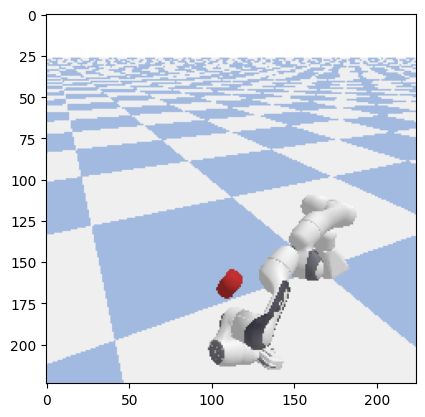

에피소드: 10, 스텝: 129
보상: -517.0563, 총 보상: -2549.9425
종료 여부: True, 컵 높이: 0.0733
거리: 0.3230, Z 차이: 0.0825, 접촉: False
--- 에피소드 10: 성공! 컵을 0.0733m 들어 올림 ---
에피소드 10 종료, 총 보상: -2549.9425

--- 테스트 결과: 10 에피소드 중 5번 성공 (성공률: 50.00%) ---
PyBullet 시뮬레이션 연결이 종료되었습니다.
--- 테스트 종료 ---


In [52]:
try:
    print("\n--- 훈련된 AI 테스트 시작 ---")

    model_path = "logs/ppo_cup_grasper_v0_200000_steps.zip"
    trained_model = PPO.load(model_path)
    test_env = CupGraspingEnv()

    # 여러 에피소드 테스트 (성공률 계산용)
    num_episodes = 10  # 10번 에피소드 테스트
    success_count = 0

    for episode in range(num_episodes):
        print(f"\n--- 에피소드 {episode + 1} 시작 ---")
        obs, info = test_env.reset()
        total_reward = 0
        max_height = 0

        for i in range(1000):
            action, _states = trained_model.predict(obs, deterministic=False)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward

            # 현재 컵 높이 확인
            cup_pos, _ = p.getBasePositionAndOrientation(test_env.cupId)
            max_height = max(max_height, cup_pos[2])

            # 디버깅 정보 출력
            gripper_pos = test_env.gripper_pos
            cup_pos = test_env.cup_pos
            distance = np.linalg.norm(gripper_pos - cup_pos)
            z_diff = abs(gripper_pos[2] - (cup_pos[2] + 0.05))
            contact_points = p.getContactPoints(bodyA=test_env.robotId, bodyB=test_env.cupId)

            # 화면 업데이트
            clear_output(wait=True)
            plt.imshow(test_env.render())
            plt.show()

            print(f"에피소드: {episode + 1}, 스텝: {i + 1}")
            print(f"보상: {reward:.4f}, 총 보상: {total_reward:.4f}")
            print(f"종료 여부: {terminated}, 컵 높이: {cup_pos[2]:.4f}")
            print(f"거리: {distance:.4f}, Z 차이: {z_diff:.4f}, 접촉: {is_contacting}")

            if terminated:
                # 성공 기준: 컵 높이 0.05m 이상
                if  cup_pos[2] > 0.05:
                    print(f"--- 에피소드 {episode + 1}: 성공! 컵을 {cup_pos[2]:.4f}m 들어 올림 ---")
                    success_count += 1
                else:
                    print(f"--- 에피소드 {episode + 1}: 실패 또는 시간 초과 (최대 높이: {max_height:.4f}m) ---")

                time.sleep(2)  # 결과 관찰 시간 단축
                break

        print(f"에피소드 {episode + 1} 종료, 총 보상: {total_reward:.4f}")

    # 성공률 출력
    success_rate = success_count / num_episodes * 100
    print(f"\n--- 테스트 결과: {num_episodes} 에피소드 중 {success_count}번 성공 (성공률: {success_rate:.2f}%) ---")

finally:
    test_env.close()
    print("--- 테스트 종료 ---")